In [1]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal

%matplotlib inline

In [4]:
dir='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/'
files='NATL60-CJM165_y*.1d_hgradb.nc'

In [5]:
tfiles=dir+files
!ls $tfiles

/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d14.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d15.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d16.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d17.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d18.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d19.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d20.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d21.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d22.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d23.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y2012m06d24.1d_hgradb.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/hg

In [19]:
hgrad_box1=xr.open_mfdataset(tfiles)['vohgradb'][:,236:993,695:1295]

In [12]:
hgrad_box1

<xarray.DataArray 'vohgradb' (time_counter: 475, y: 600, x: 757)>
dask.array<getitem, shape=(475, 600, 757), dtype=float64, chunksize=(1, 600, 757)>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2012-06-14T12:01:04 ...
Dimensions without coordinates: y, x
Attributes:
    units: s^{-2}
    valid_min: -1.0
    valid_max: 1.0
    long_name: Horizontal gradient of buoyancy.
    short_name: vohgradb
    iweight: 1
    online_operation: N/A
    axis: 
    savelog10: 0.0

In [20]:
hgradb_box1_stack=hgrad_box1.stack(z=('time_counter','y','x'))

In [14]:
hgradb_box1_stack

<xarray.DataArray 'vohgradb' (z: 215745000)>
dask.array<reshape, shape=(215745000,), dtype=float64, chunksize=(454200,)>
Coordinates:
  * z             (z) MultiIndex
  - time_counter  (z) datetime64[ns] 2012-06-14T12:01:04 2012-06-14T12:01:04 ...
  - y             (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - x             (z) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Attributes:
    units: s^{-2}
    valid_min: -1.0
    valid_max: 1.0
    long_name: Horizontal gradient of buoyancy.
    short_name: vohgradb
    iweight: 1
    online_operation: N/A
    axis: 
    savelog10: 0.0

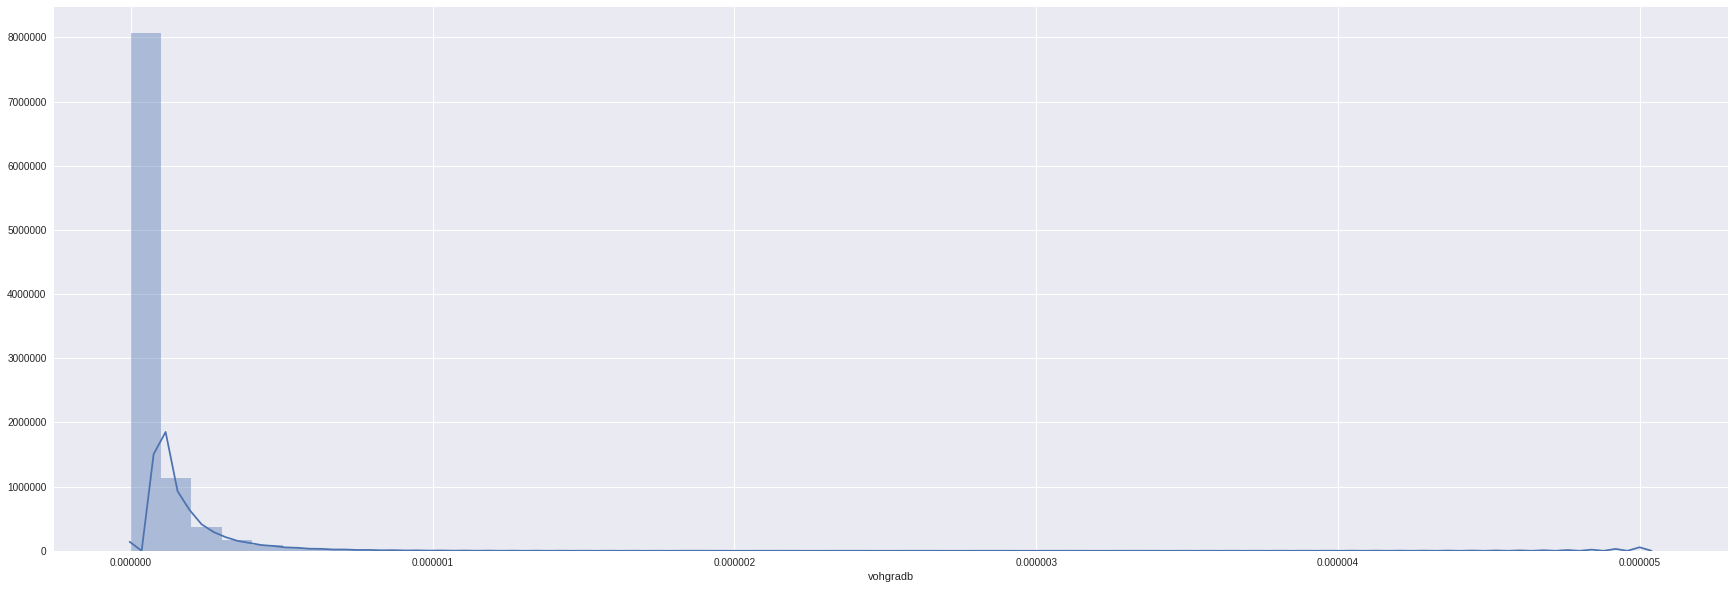

In [21]:
fig=plt.figure(figsize=(30,10))

sns.distplot(hgradb_box1_stack)

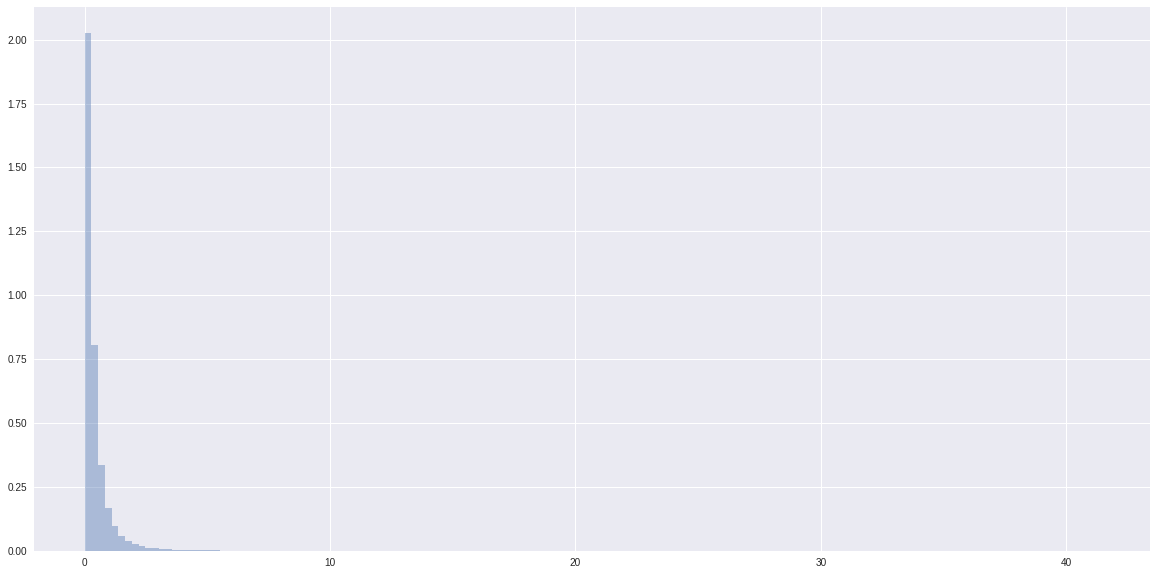

In [63]:
hgrad_box2=xr.open_mfdataset(tfiles)['vohgradb'][:,234:974,1288:1889]
hgradb_box2_stack=hgrad_box2.stack(z=('time_counter','y','x'))
hgradb_box2_stack_array=hgradb_box2_stack.values
hgradb_box2_stack_array[hgradb_box2_stack_array==0]=np.nan
hgradb_box2_stack_mask=ma.masked_invalid(hgradb_box2_stack_array)


In [ ]:
fig=plt.figure(figsize=(20,10))
sns.distplot(1e7*hgradb_box2_stack_mask,norm_hist=True,kde=False,bins=150)

In [66]:
np.median(hgradb_box2_stack_mask)

2.343155003359243e-08

In [65]:
hgradb_box2_stack_mask.

AttributeError: 'MaskedArray' object has no attribute 'median'

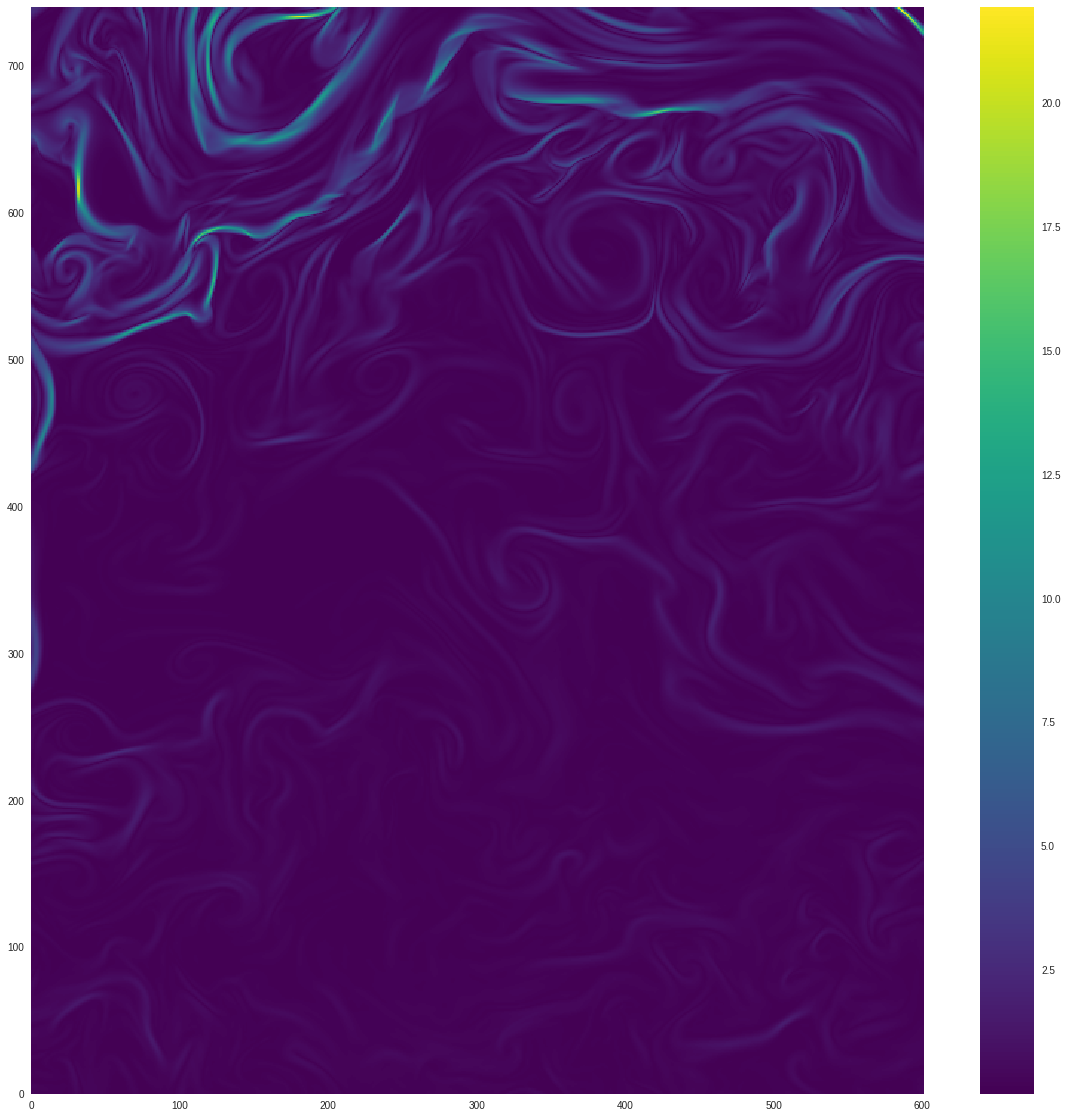

In [60]:
lat=xr.open_mfdataset(tfiles)['nav_lat'][0,234:974,1288:1889]
lon=xr.open_mfdataset(tfiles)['nav_lon'][0,234:974,1288:1889]
fig=plt.figure(figsize=(20,20))
plt.pcolormesh(1e7*hgrad_box2[0],cmap='viridis')
plt.colorbar()

In [36]:
def hist_box(imin,imax,jmin,jmax,boxname):
    hgrad_box=xr.open_mfdataset(tfiles)['vohgradb'][:,jmin:jmax,imin:imax]
    hgradb_box_stack=hgrad_box.stack(z=('time_counter','y','x'))
    hgradb_box_stack_array=hgradb_box_stack.values
    hgradb_box_stack_array[hgradb_box_stack_array==0]=np.nan
    hgradb_box_stack_mask=ma.masked_invalid(hgradb_box_stack_array)
    fig=plt.figure(figsize=(30,10))
    sns.distplot(1e6*hgradb_box_stack_mask,norm_hist=True,kde=False,bins=50)
    plt.title(boxname)
    

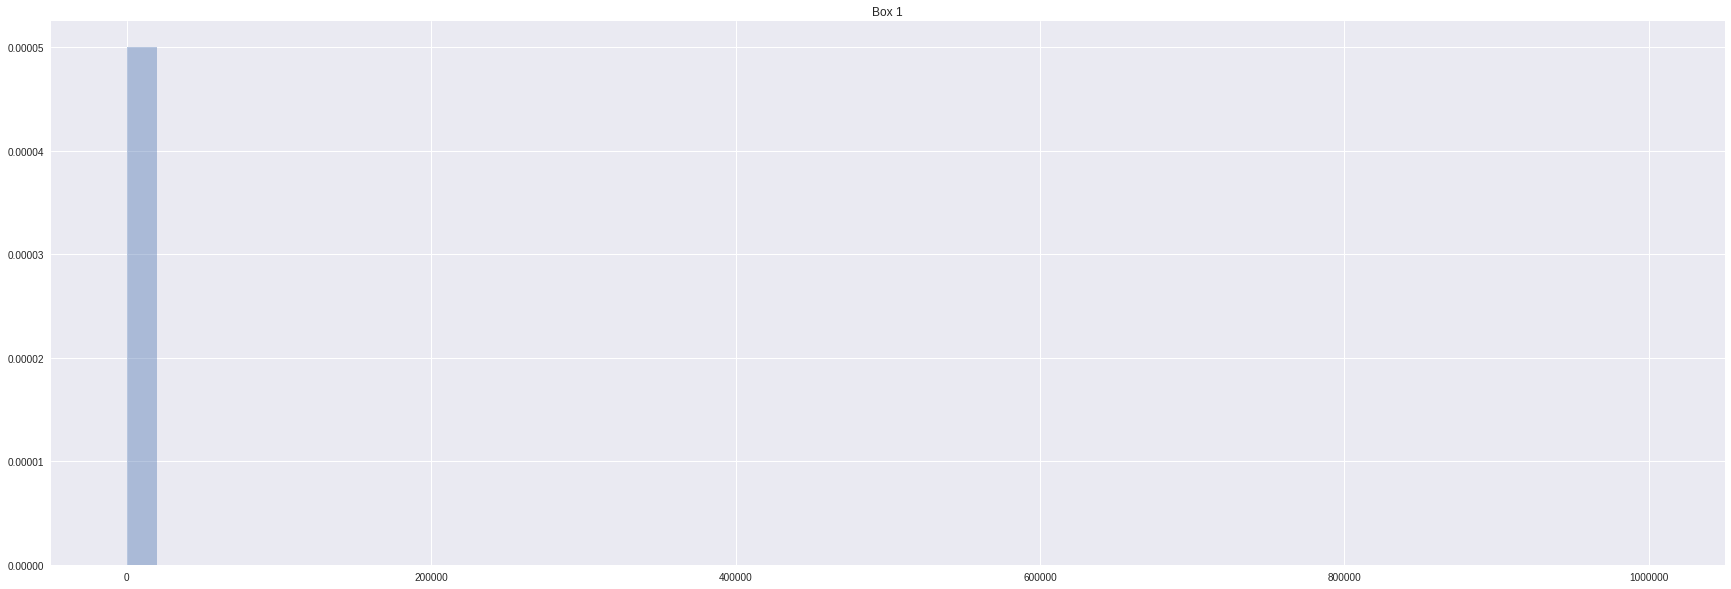

In [37]:
hist_box(695,1295,236,993,'Box 1')

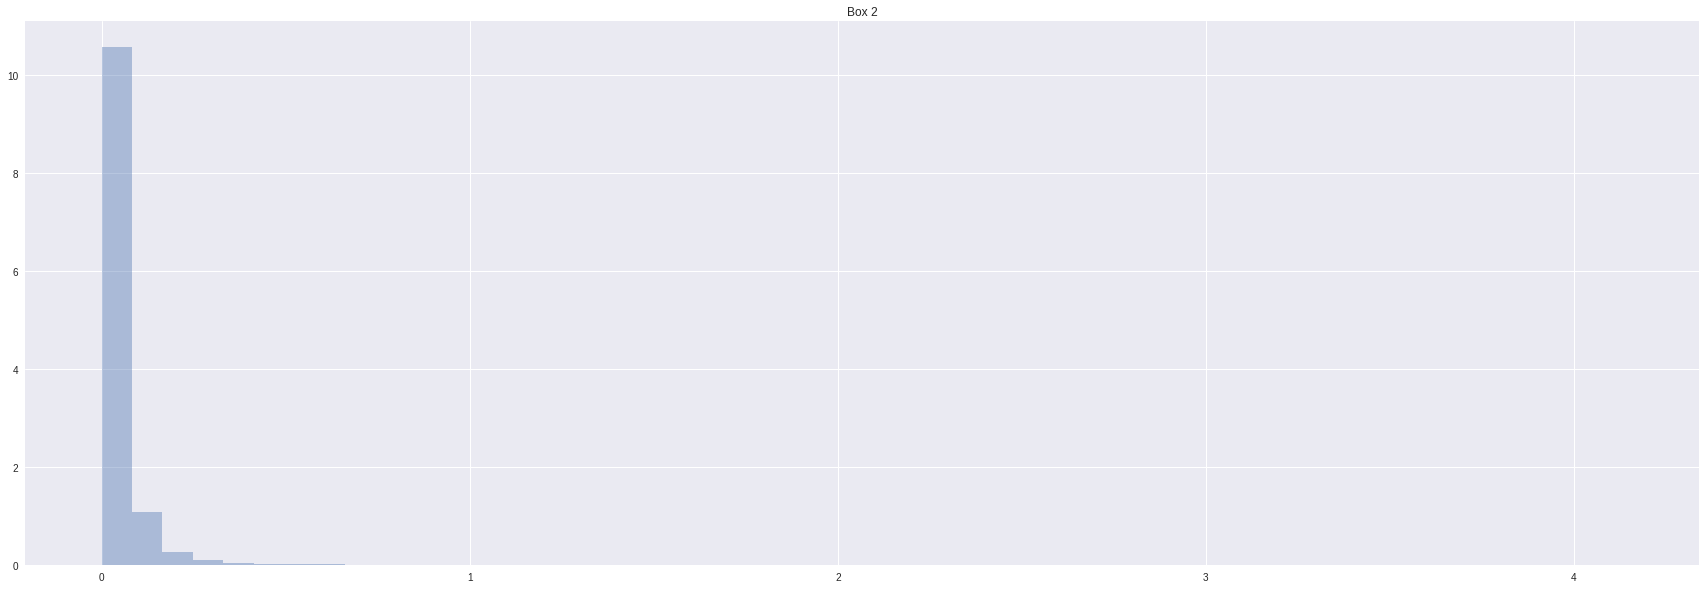

In [38]:
hist_box(1288,1889,234,974,'Box 2')

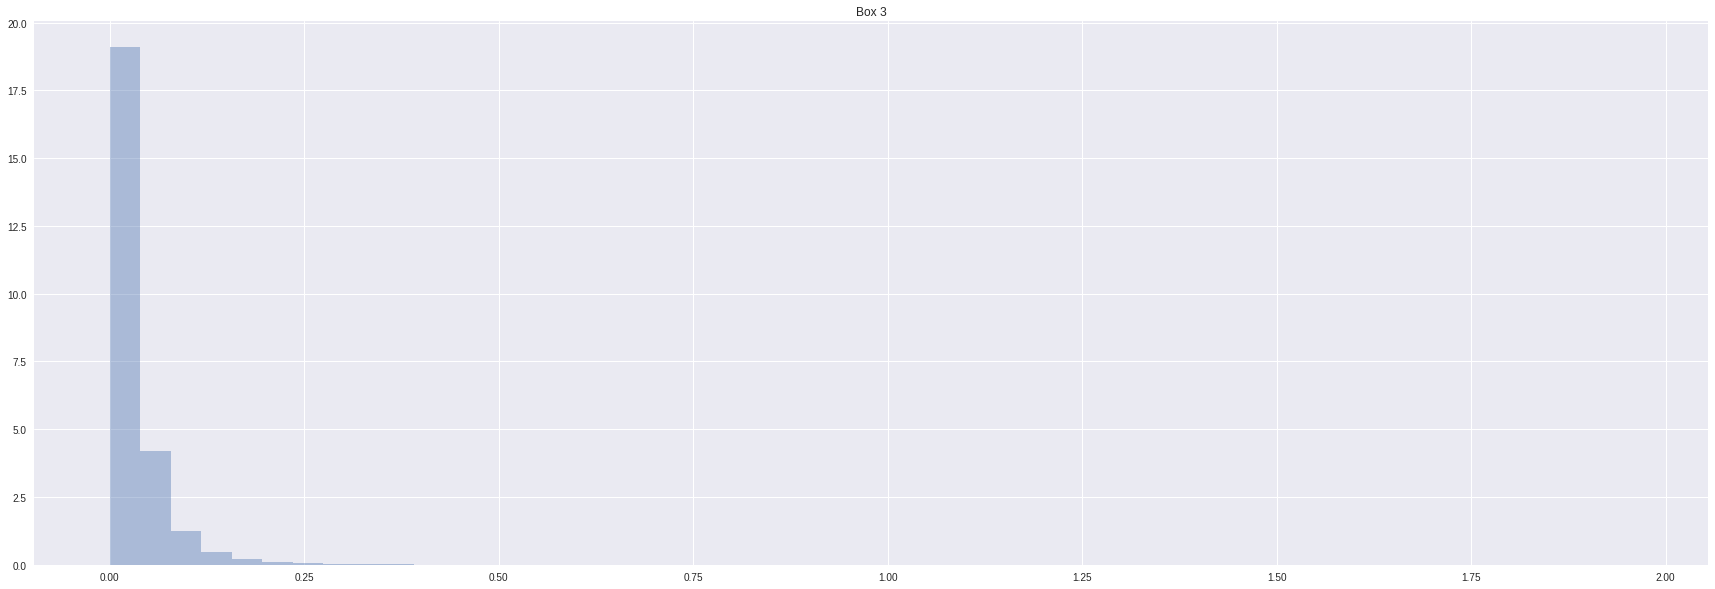

In [39]:
hist_box(1891,2488,232,961,'Box 3')

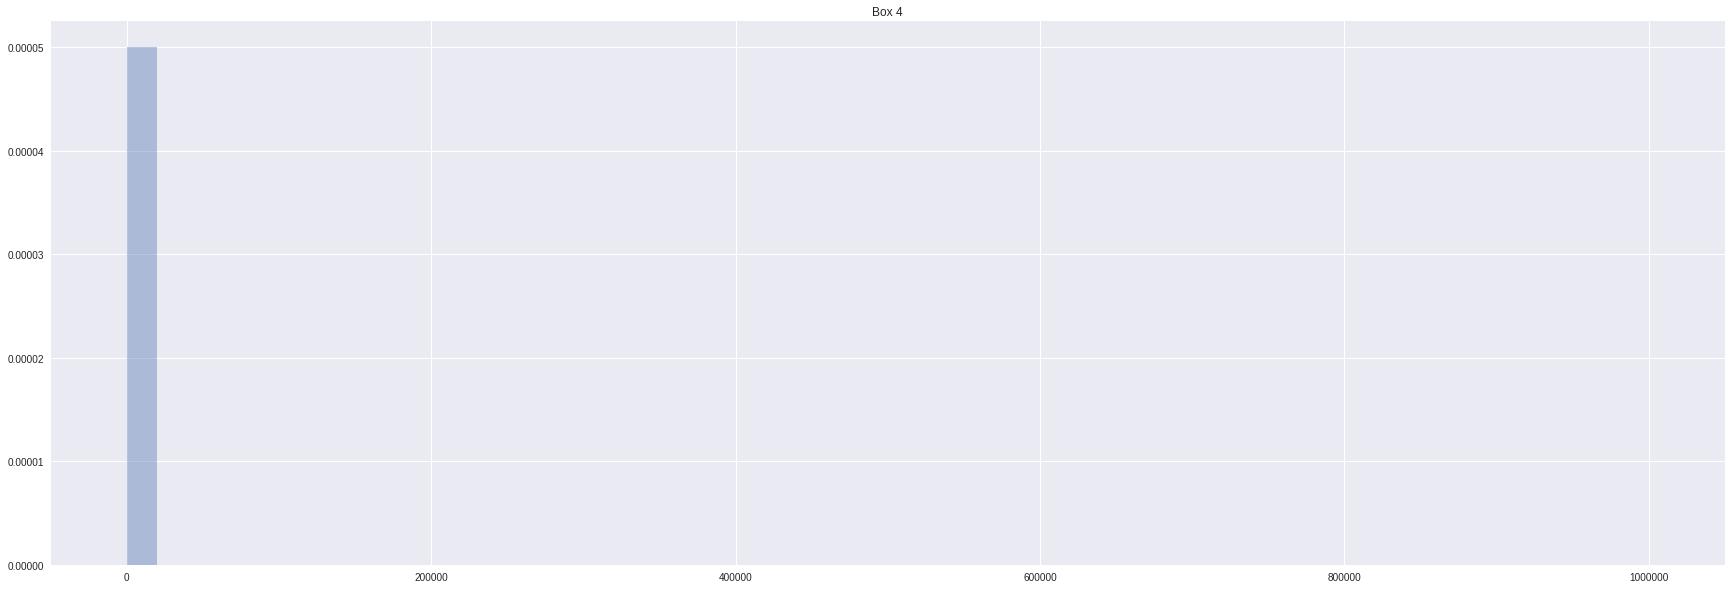

In [40]:
hist_box(2491,3087,232,959,'Box 4')

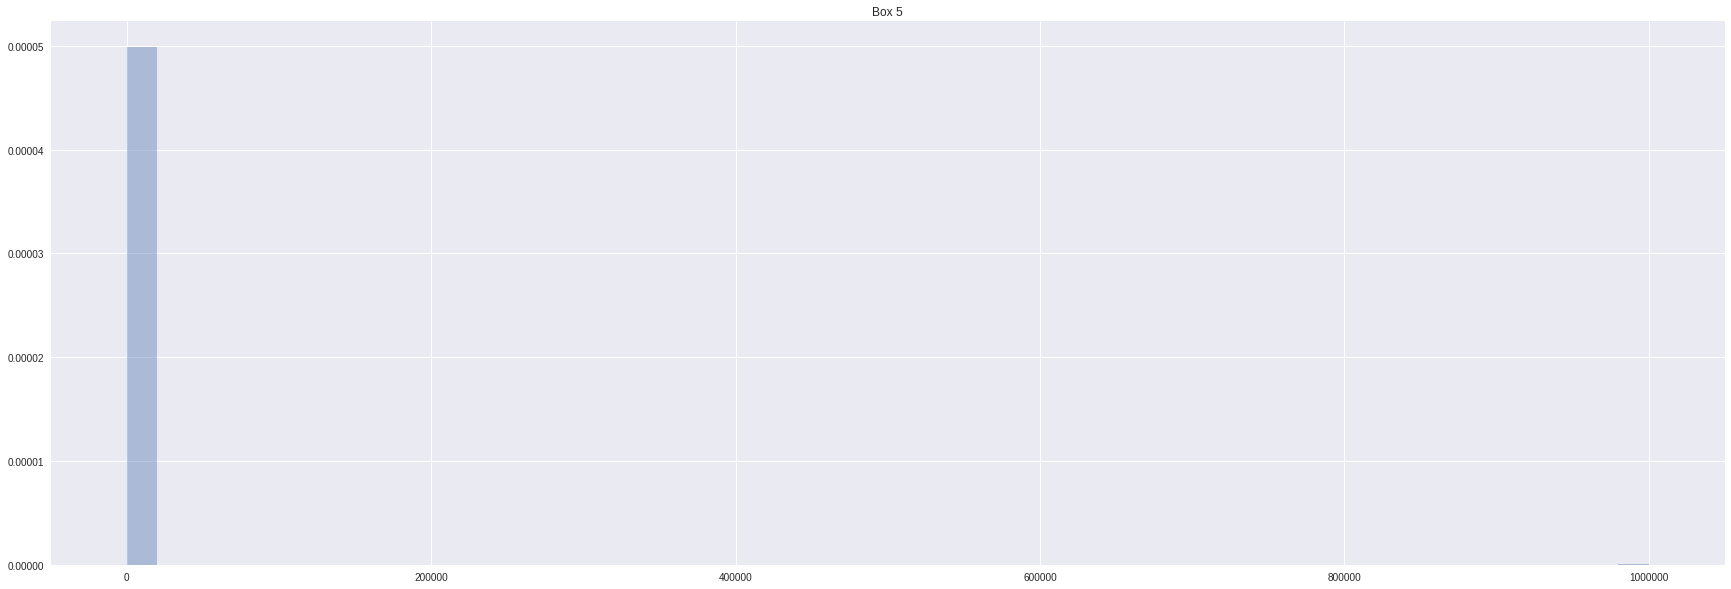

In [41]:
hist_box(3088,3686,232,957,'Box 5')

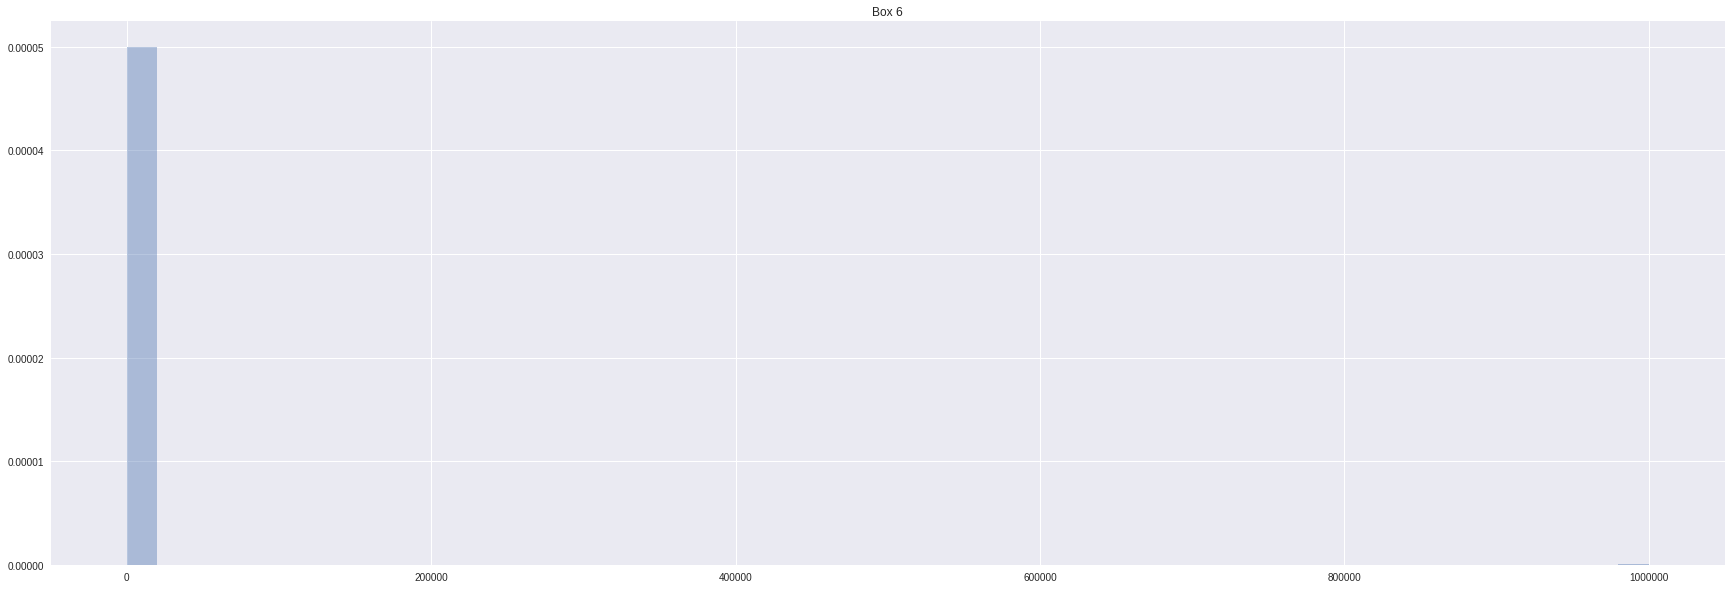

In [42]:
hist_box(3684,4286,232,963,'Box 6')

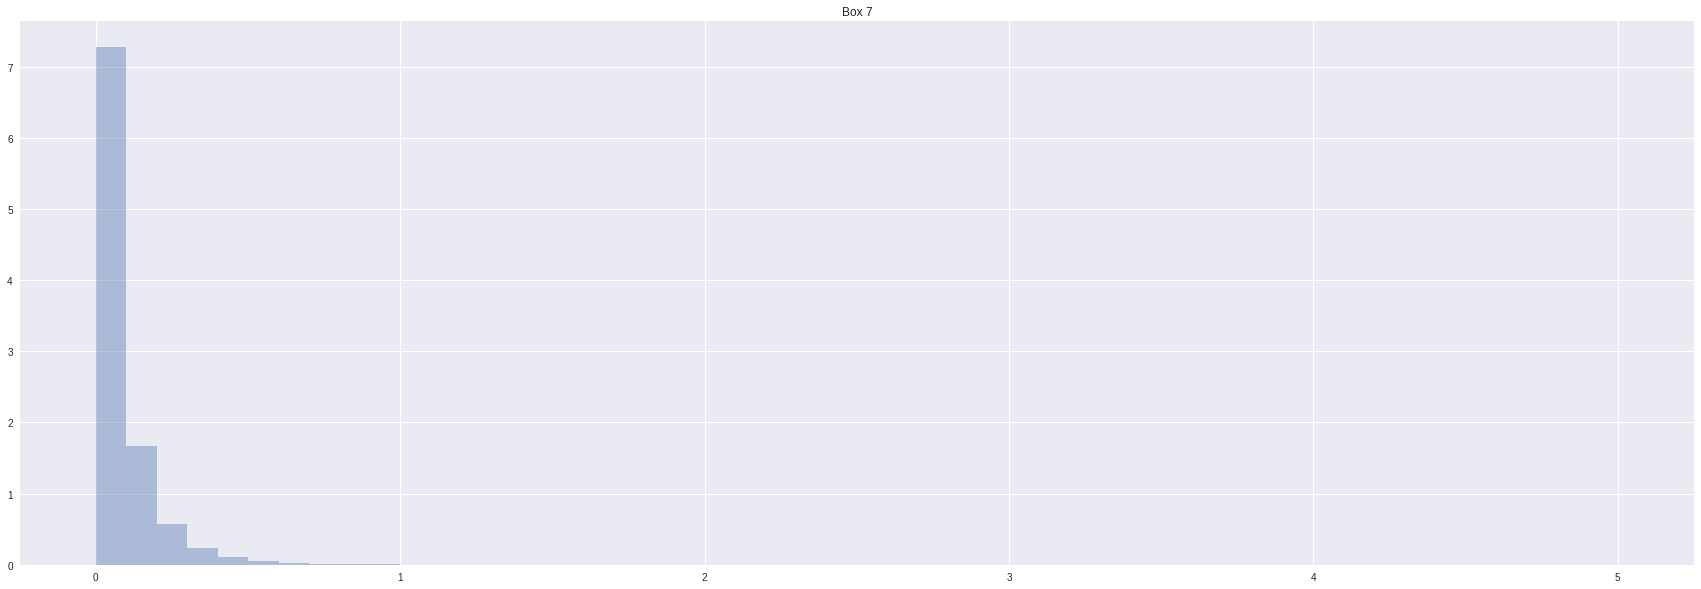

In [43]:
hist_box(1931,2494,968,1802,'Box 7')

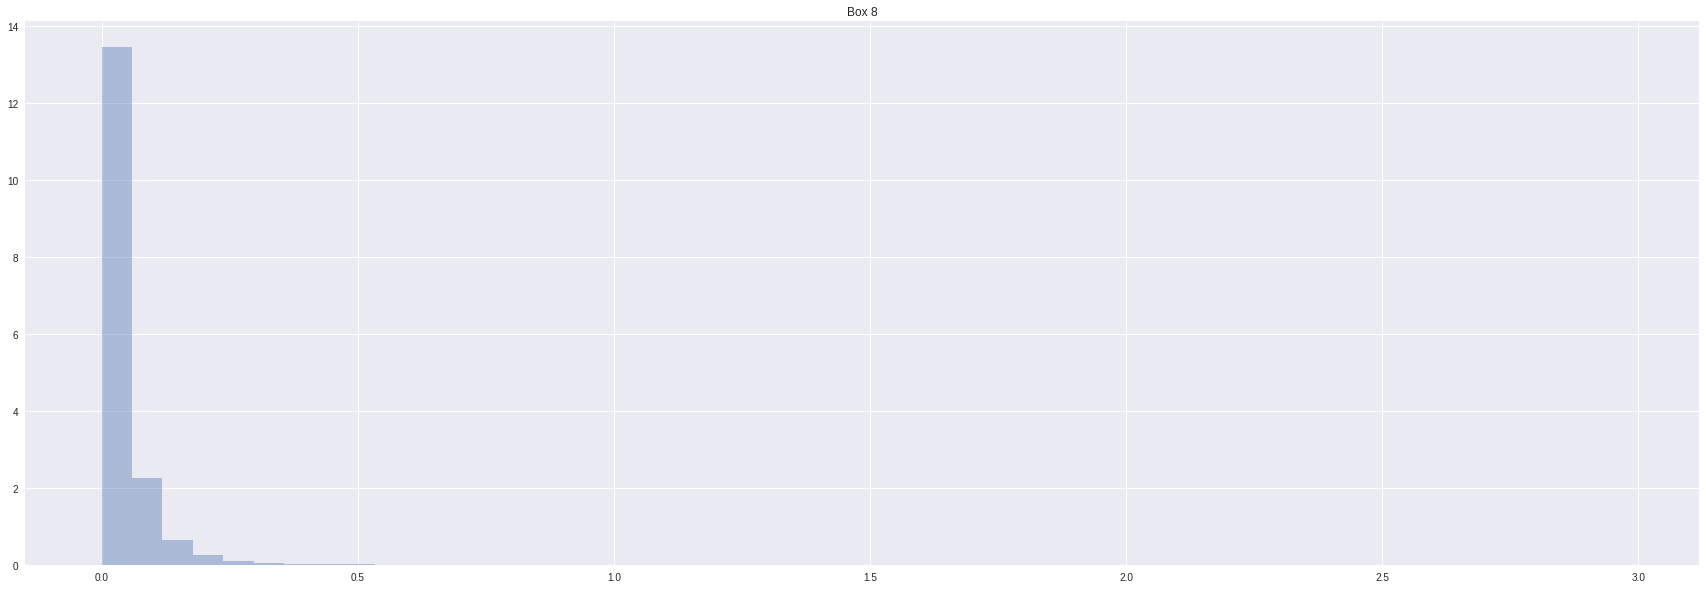

In [44]:
hist_box(2493,3088,958,1783,'Box 8')

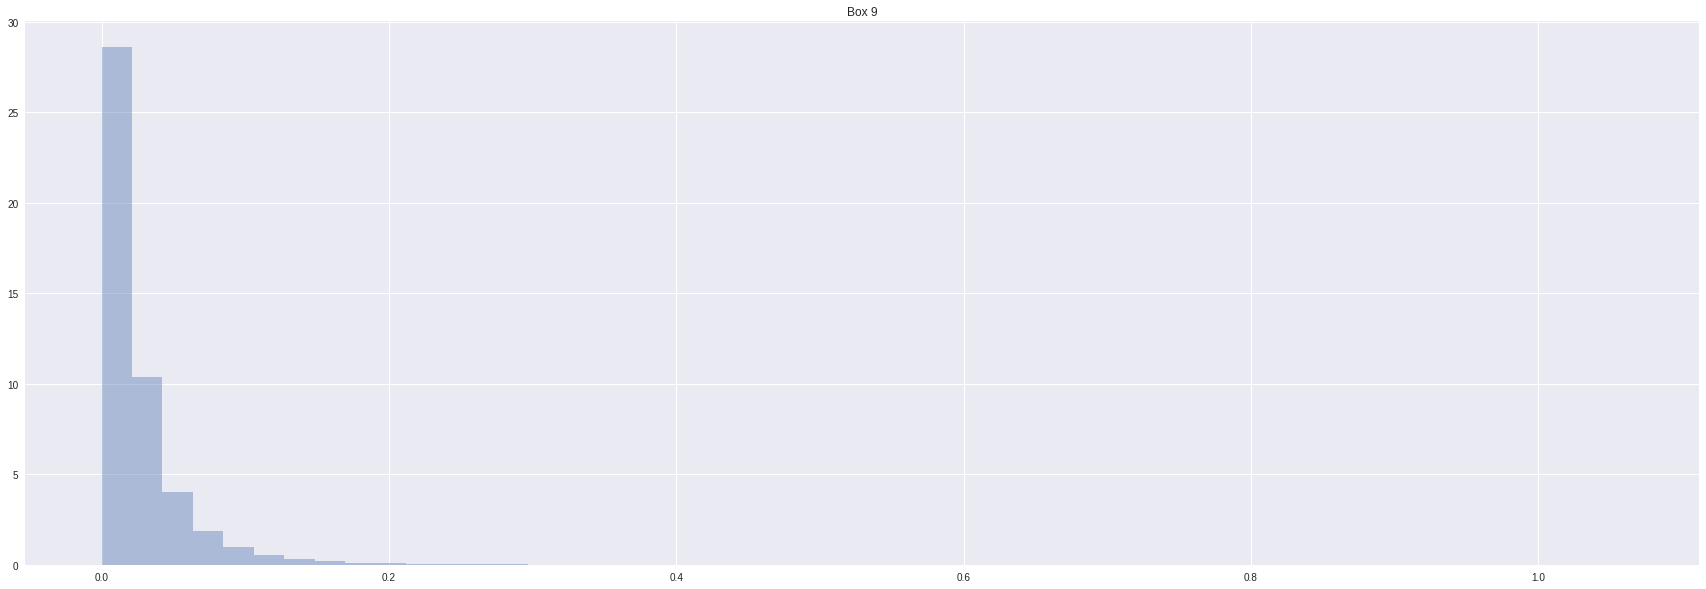

In [45]:
hist_box(3088,3676,957,1770,'Box 9')

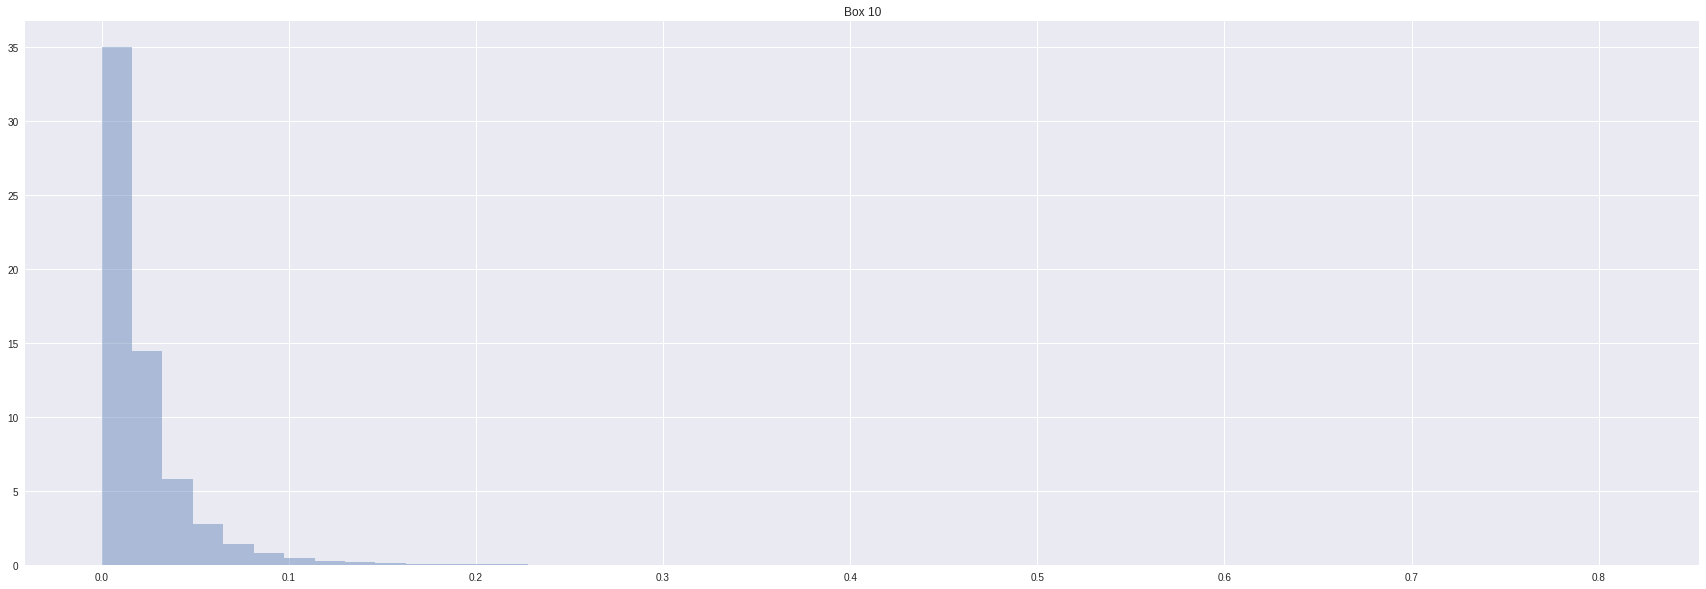

In [46]:
hist_box(3681,4247,962,1778,'Box 10')

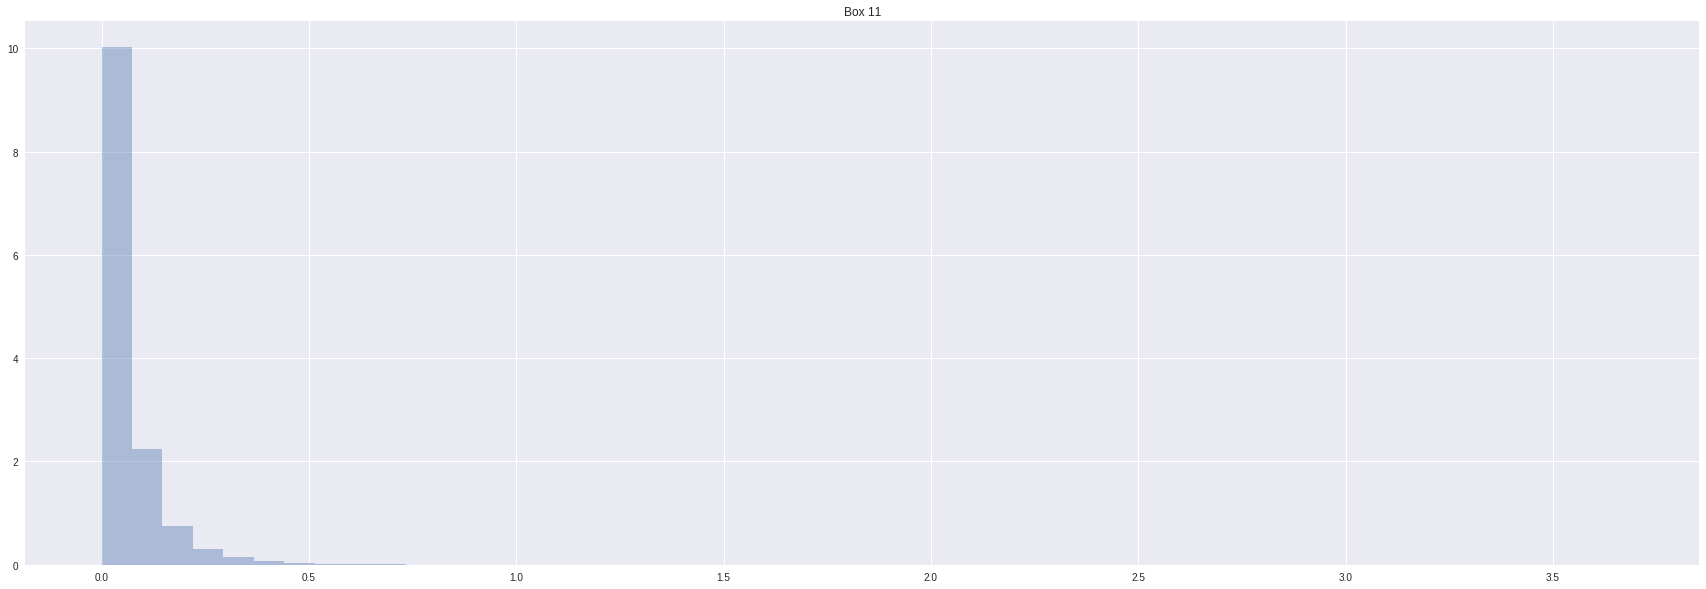

In [47]:
hist_box(1761,2239,1833,2785,'Box 11')

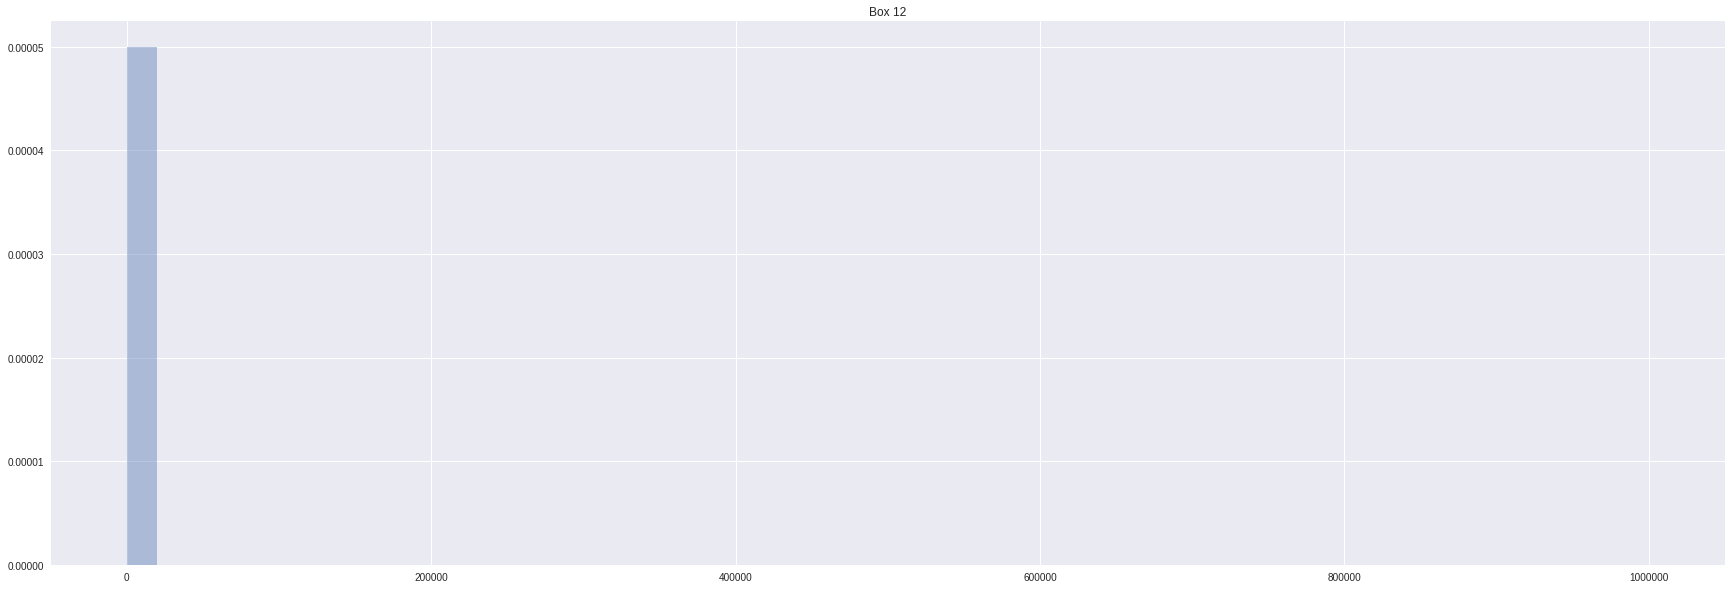

In [48]:
hist_box(2309,2835,1777,2742,'Box 12')

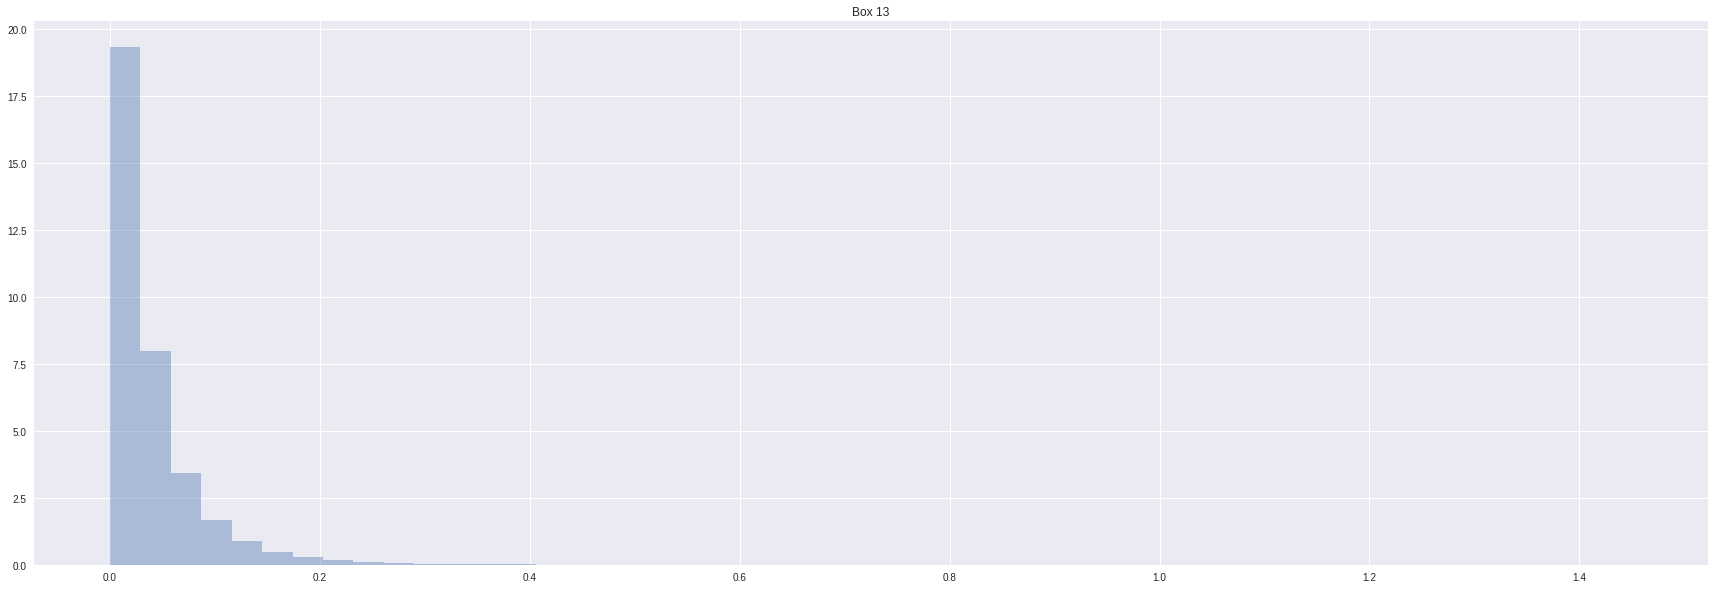

In [49]:
hist_box(2813,3375,1773,2696,'Box 13')

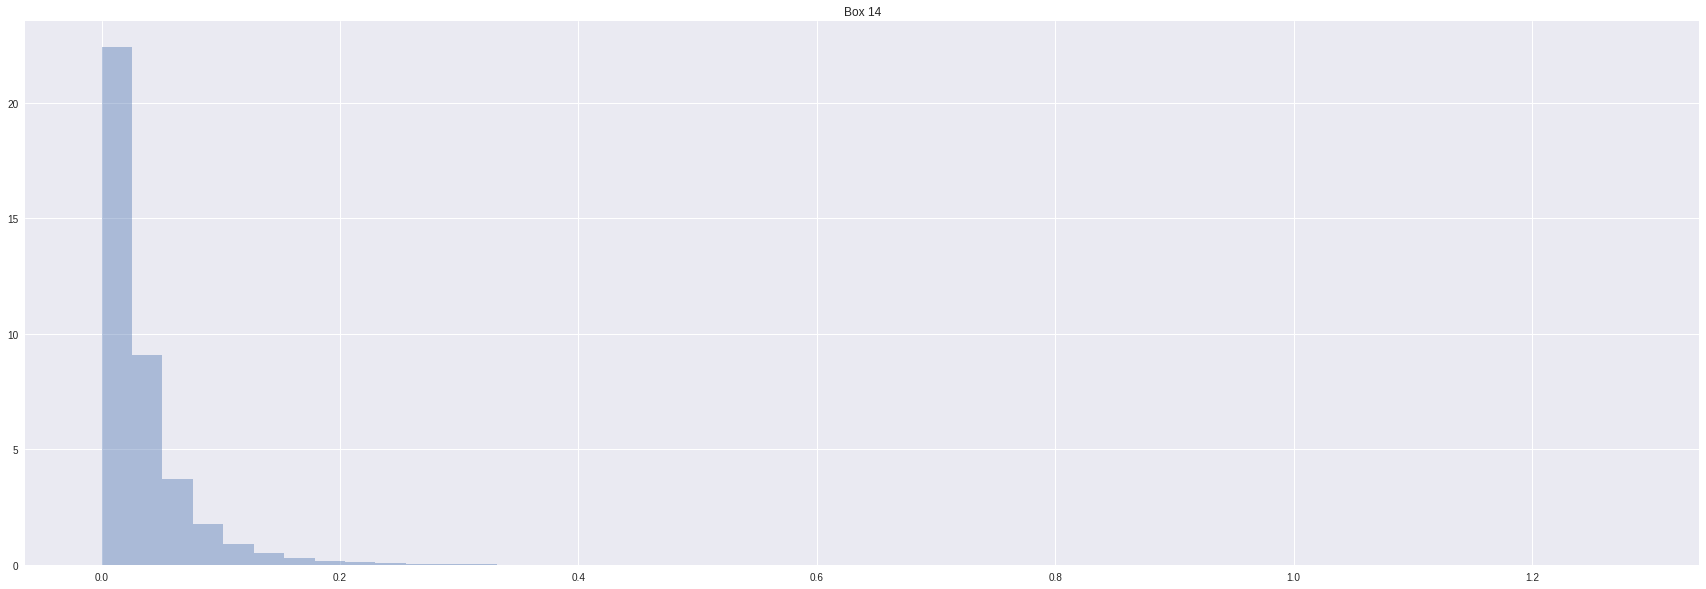

In [50]:
hist_box(3374,3926,1780,2698,'Box 14')